In [2]:
import gym
from gym import wrappers
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from torch.utils.tensorboard import SummaryWriter


In [25]:


class Replay() :
    def __init__(self, capacity):
        self.capacity =capacity
        self.memory = []
    def put(self, tran_data,flag):
        """ it saves a transition depending upon  the cpacity.
        It deletes the transiotion depending upon the flag value.
        if flag value is 1 then it randomly deletes the transition or it delets for the 
        first position"""
        self.memory.append(tran_data)
        if len(self.memory) == self.capacity:
            if flag == 1:
                r = random.choice(range(0,self.capacity))
                del self.memory[r]
            else:
                del self.memory[0]
    def sample_batch(self, batch_size):
        """returns the batch of randomly selected transition samples"""
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

class NeuralNetwork(nn.Module):
    def __init__(self, hl):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, hl)
        self.l2 = nn.Linear(hl, hl)
        self.l3 =  nn.Linear(hl, hl)
        self.l4 =  nn.Linear(hl, 2)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x


class DQN():
    def __init__(self, batch_size, epsilon_start, epsilon_end, lr, gamma, hl_size, re_memory_size, episodes, targe_change, decay_rate):
        self.batch_size = batch_size
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.gamma = gamma 
        self.re_memory = Replay(re_memory_size)
        self.net = NeuralNetwork(hl_size).float()
        self.optimizer = optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
#         self.loss =F.smooth_l1_loss()
        self.target_net = NeuralNetwork(hl_size).float()
        self.count =0
        self.episodes = episodes
#         self.totalloss = []
        self.targe_change = targe_change
        self.decay_rate = decay_rate
        self.epsilon =  epsilon_start
        self.episode_count = 0
       
        


    def select_action(self, env):
       
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                        math.exp(-1. * self.count / self.decay_rate)
        self.count+=1
        if random.uniform(0, 1) < self.epsilon:
            action = env.action_space.sample()
        else :
            action = np.argmax(self.net.forward(torch.tensor(env.state).unsqueeze(0).float()).detach().numpy())
#             print(action)
        return action

    def train_network(self):
        if len(self.re_memory) < self.batch_size:
            return 0
            bs = len(self.re_memory)
            
            
        else :
            bs = self.batch_size
            
        s_batch = self.re_memory.sample_batch(bs)
        batch_state, batch_action, batch_next_state, batch_reward, batch_ter = zip(*s_batch)
        
        batch_state = torch.tensor(batch_state).float()
        batch_action = torch.tensor(batch_action).reshape([bs,1])
        batch_next_state = torch.tensor(batch_next_state).float()
        batch_reward = torch.tensor(batch_reward).float().reshape([bs,1])
        batch_ter = torch.tensor(batch_ter).reshape([bs,1])
#         print(len(batch_state),"wqdqd")
#         l = []
#         print("batch_ter",batch_ter[0])
        
            
#         print("batch_action",batch_action)
#         print("batch_next_state",batch_next_state.size())
#         print("batch_reward",batch_reward.size())
        
        current_q_values = self.net(batch_state).gather(1, batch_action)
        # expected Q values are estimated from actions which gives maximum Q value
        max_next_q_values = self.target_net(batch_next_state).max(1).values.reshape([bs,1]).detach()
        expected_q_values = batch_reward + (self.gamma * max_next_q_values)
#         print("expected_q_values",expected_q_values.size())
#         print("batch_ter",batch_ter.size())
#         print("batch_reward",batch_reward.size())
#         print("current_q_values",current_q_values.size())
        mu = 0
        for f, g in zip(batch_ter, batch_reward):
            if f == True:
                expected_q_values[mu] = g
            mu+=1
                
#         print(current_q_values.size(), expected_q_values.size())
#         print("before",torch.sum(self.net.l1.weight.data))
#         print("expected_q_values",expected_q_values.size())
#         print("current_q_values",current_q_values.size())
        loss= F.smooth_l1_loss(current_q_values, expected_q_values)
#         print(loss.item())
#         self.totalloss.append(loss.item())
        self.optimizer.zero_grad()
#         writer.add_scalar('loss per batch', loss.item(), len(self.totalloss))
        loss.backward()
        for param in self.net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
#         print(loss.item(), "dwedwedw")
#         print("after",torch.sum(self.net.l1.weight.data))
        return loss.item()




    def episode(self, env):
        state = env.reset()
        step_count = 0
        episode_loss = 0
        
        if self.episode_count % self.targe_change == 0:
#                 print("fakru sarkaar")
                self.target_net = copy.deepcopy(self.net)
        self.episode_count +=1
#         self.epsilon = max(self.epsilon - (self.epsilon_start-self.epsilon_end)/self.decay_rate, .01)
        total_reward = 0
        done = False
#         print(self.epsilon)
#         self.count +=1
        
        while not done:
            
            action = self.select_action(env)
#             print(action,"wedwedw")
            next_state, reward, done, _ = env.step(action)
            if done :
                next_state = [0,0,0,0]

            reward = reward if not done else -reward # this changed
           
#         print("reward",r)
#             if step_count >=200 :
#                 reward = -1 
            self.re_memory.put([state,action,next_state,reward, done],1)
            step_count +=1
            total_reward+=reward

            
            ls = self.train_network()
            episode_loss+= ls 
            if step_count >=200:
                break
            state = next_state
            
#         print("r",r)
        return step_count, total_reward, episode_loss#/step_count

        

0
100
200
300
400
500
600
700
800
900


No handles with labels found to put in legend.


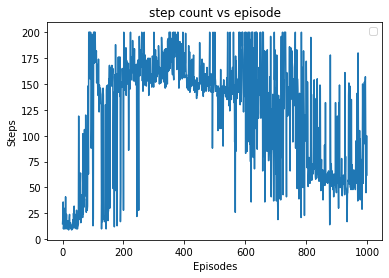

No handles with labels found to put in legend.


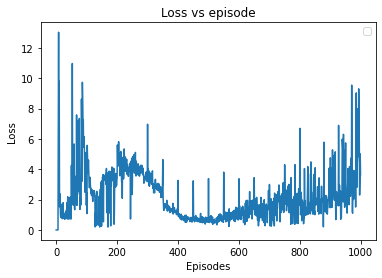

In [26]:

np.random.seed(0)
torch.manual_seed(0)
episodes = 1000 # number of episodes
epsilon_start = 1 # e-greedy threshold start value
epsilon_end = .05  # e-greedy threshold end value
decay_rate = 500
iterations = 30
gamma = .99 # Q-learning discount factor
lr = 1e-4 # NN optimizer learning rate
hl_size = 128  # NN hidden layer size
batch_size = 128 # Q-learning batch size
re_memory_size = 100000
targe_change = 50

# env = gym.make('CartPole-v0')
# env = env.unwrapped

# model = DQN(batch_size, epsilon_start, epsilon_end, lr, gamma, hl_size, re_memory_size, episodes, targe_change, decay_rate)

# writer = SummaryWriter('runs/dqn', comment="LR_0.0001_BATCH_128_episodes_5000_gamma_0.99_re_memory_size_1000000_epsilon_start_1_epsilon_end_.005_targe_change_1")

# writer.add_graph(model.net, input_to_model=torch.tensor([[2,4,5,6]]).float(), verbose=False)



# default `log_dir` is "runs" - we'll be more specific here
step = []
loss = []
enu = [100000]
for re_memory_size in enu:
    env = gym.make('CartPole-v0')
    env = env.unwrapped
    model = DQN(batch_size, epsilon_start, epsilon_end, lr, gamma, hl_size, re_memory_size, episodes, targe_change, decay_rate)
    a = []
    b = []
    c = []
    for p in range(episodes):
        if p % 100 == 0:
            print(p)

        i,j, k =  model.episode(env)
    #     if p % 50 == 0:
    #     writer.add_scalar('step count per episode', i, p)
    #     writer.add_scalar('reward per episode', j, p)
    #     writer.add_scalar('loss per episode', k, p)
        a.append(i)
        b.append(j)
        c.append(k)
    step.append(a)
    loss.append(c)
    env.close()
    
#     writer.add_scalar('reward', j, p)
# writer.close()
# plt.switch_backend('agg')
# fig = plt.figure()
for el, i in zip(step ,enu):
    plt.xlabel("Episodes")
    plt.ylabel("Steps")
    plt.title("step count vs episode")
    plt.plot(np.arange(episodes),el )
plt.legend()
plt.show()
plt.close()
# plt.xlabel("Episodes")
# plt.ylabel("Rewards")
# plt.title("Rewards vs episode")
# plt.plot(np.arange(episodes),b)
# plt.show()
# env.close()
for el,i in zip(loss, enu):
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Loss vs episode")
    plt.plot(np.arange(episodes),el)
plt.legend()
plt.show()
plt.close()

In [10]:
sum(a[450:550])/100

0.0

No handles with labels found to put in legend.


173.86 305


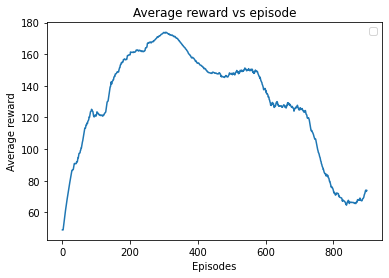

In [27]:


nm = "dqwd"
for el, j in zip(step ,enu):
    xr = []
    yr = []
    e= 0
    m = 0
    for i in range(episodes-100):
        op = sum(el[i:i+100])/100
        if op>m:
            m = op
            e = i
        yr.append(op)
        xr.append(i)
    plt.xlabel("Episodes")
    plt.ylabel("Average reward")
    plt.title("Average reward vs episode")
    plt.plot(xr,yr)
    print(m,e)
plt.legend()
plt.show()


{50:14.6, }